In [87]:
# basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# preprocess
from sklearn.preprocessing import LabelEncoder

# model
import lightgbm as lgb

# other
import time
import sys
import gc

In [7]:
items = pd.read_csv('../data/input/items.csv')
shops = pd.read_csv('../data/input/shops.csv')
cats = pd.read_csv('../data/input/item_categories.csv')
train = pd.read_csv('../data/input/sales_train.csv')

In [71]:
# set index to ID to avoid droping it later
test  = pd.read_csv('../data/input/test.csv').set_index('ID')

# preprocess train

In [8]:
# processing outlier, negative value
train = train[train.item_cnt_day < 100000]
train = train[train.item_price < 1250]

median = train[(train.shop_id==32)&\
                     (train.item_id==2973)&\
                     (train.date_block_num==4)&\
                     (train.item_price>0)].item_price.median()
train.loc[train.item_price < 0, 'item_price'] = median

In [9]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# preprocess shops

In [10]:
# create column:shop_city_name
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city_name'] = shops['shop_name'].apply(lambda x:x.split(' ')[0])
# proofreading shop_city_name
shops.loc[shops['city_name']=='!Якутск', \
         'city_name'] = 'Якутск'
# Encoding
shops['city_code'] = LabelEncoder().fit_transform(shops['city_name'])
shops = shops[['shop_id','city_code']]

# preprocess cats

In [11]:
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

# sub type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

# How deal with Чистые носители (штучные) & blank media (piece) ???

In [12]:
items.drop(['item_name'], axis=1, inplace=True)

# Create Monthly Sale

In [13]:
# test data is (shop_id) x (item_id)
# so create train-matrix:(shop_id) x (item_id)

matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())),\
                           dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [14]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [15]:
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16))

train_month = matrix.copy()

# Test set

In [16]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [17]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)

# Shops/Items/Cats

In [18]:
matrix = pd.merge(matrix, shops, on='shop_id', how='left')
matrix = pd.merge(matrix, items, on='item_id', how='left')
matrix = pd.merge(matrix, cats, on='item_category_id', how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

# Target Lags

In [19]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

In [20]:
matrix = lag_feature(df=matrix, lags=[1, 2, 3, 4, 5, 6, 9, 12], col='item_cnt_month')

# Mean encoded features
groupby  
 - date_block_num
 - date_block_num, item_id
 - date_block_num, shop_id
 - date_block_num, item_category_id
 - date_block_num, shop_id, item_category_id
 - date_block_num, shop_id, type_code
 - date_block_num, shop_id, subtype_code
 - date_block_num, city_code
 - date_block_num, item_id, city_code
 - date_block_num, type_code
 - date_block_num, subtype_code

In [21]:
group = matrix.groupby('date_block_num').agg({'item_cnt_month':['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

In [22]:
matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(df=matrix, lags=[1], col='date_avg_item_cnt')
matrix.drop('date_avg_item_cnt', axis=1, inplace=True)

In [23]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

In [24]:
matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [25]:
ts = time.time()

group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1, 2, 3, 6, 9, 12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

ts - time.time()

-23.193681478500366

In [26]:
ts = time.time()

group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

6.127365589141846

In [27]:
ts = time.time()

group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

6.625975847244263

In [28]:
ts = time.time()

group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

6.6301398277282715

In [29]:
ts = time.time()

group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

6.815263986587524

In [30]:
ts = time.time()

group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

6.804862022399902

In [31]:
ts = time.time()

group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

10.338124990463257

In [32]:
ts = time.time()

group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

6.915813684463501

In [33]:
ts = time.time()

group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

6.963634490966797

# Trend Features
Price trend for the last six months.

In [34]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [35]:
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [36]:
lags = [1, 2, 3, 4, 5, 6]
matrix = lag_feature(df=matrix, lags=lags, col='date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
    (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price'])\
    / matrix['item_avg_item_price']

In [37]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [38]:
ts = time.time()

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

145.60349917411804

In [39]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [40]:
group = train.groupby(['date_block_num', 'shop_id']).agg({'revenue':['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

In [41]:
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [42]:
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = \
(matrix['date_shop_revenue'] - matrix['shop_avg_revenue'])/ matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

# Special Feature
month's days count, item-shop last&first sale, item last&first sale

In [43]:
train['date'] = pd.to_datetime(train['date'], format="%d.%m.%Y")
train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['day'] = train.date.dt.day

In [44]:
# create month & number of days in a month
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
matrix['day_cnt'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>
    Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num.  
    Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.  
    date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

ts = time.time()

cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)

"""
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        
        matrix.at[idx, 'item_shop_last_sale'] = \
        row.date_block_num - last_date_block_num
        
        cache[key] = row.date_block_num
"""

for row in matrix.itertuples():
    idx = getattr(row, 'Index')
    item_id = getattr(row, 'item_id')
    shop_id = getattr(row, 'shop_id')
    date_block_num = getattr(row, 'date_block_num')
    item_cnt_month = getattr(row, 'item_cnt_month')
    
    key = str(item_id) + " " + str(shop_id)
    if key not in cache:
        if item_cnt_month != 0:
            cache[key] = date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = \
            date_block_num - last_date_block_num
        cache[key] = date_block_num

time.time() - ts

ts = time.time()

cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

"""
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = \
            row.date_block_num - last_date_block_num
            
            cache[key] = row.date_block_num
"""

for row in matrix.itertuples():
    idx = getattr(row, 'Index')
    item_id = getattr(row, 'item_id')
    item_cnt_month = getattr(row, 'item_cnt_month')
    date_block_num = getattr(row, 'date_block_num')
    
    key = item_id
    if key not in cache:
        if item_cnt_month != 0:
            cache[key] = date_block_num
    else:
        last_date_block_num = cache[key]
        if date_block_num > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] =\
            date_block_num - last_date_block_num
            cache[key] = date_block_num

time.time() - ts

ts = time.time()

matrix['item_shop_first_sale'] = \
matrix['date_block_num'] - \
matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')

matrix['item_first_sale'] = \
matrix['date_block_num'] - \
matrix.groupby('item_id')['date_block_num'].transform('min')

time.time() - ts

## Easier & faster method to calculate first & last sale item sales

In [45]:
ts = time.time()

# Get the list of block for each item was sold from monthly train data
sale_group = train_month.groupby('item_id')['date_block_num'].\
    apply(list).reset_index(name='date_block_num')

# Get the first & last element from the block list
sale_group['item_first_sale'] = sale_group['date_block_num'].apply(lambda x:x[0])
sale_group['item_last_sale'] = sale_group['date_block_num'].apply(lambda x:x[-1])

# Fill NA with -1(there is no sales)
sale_group = sale_group.fillna(-1)

#display(sale_group)

# Merge with main dataset
"""
matrix = pd.merge(
    matrix,
    sale_group.drop('data_block_num', axis=1), 
    on=['item_id'],
    how='left'
)
"""

matrix = pd.merge(
    matrix, sale_group.drop('date_block_num', axis=1),
    on=['item_id'],
    how='left'
)

print(time.time() - ts)

4.440839052200317


In [46]:
ts = time.time()

# Get the list of block for each item was sold from monthly train data
sale_group = train_month.groupby(['item_id', 'shop_id'])['date_block_num'].\
    apply(list).reset_index(name='date_block_num')

# Get the first & last element from the block list
sale_group['item_shop_first_sale'] = sale_group['date_block_num'].apply(lambda x:x[0])
sale_group['item_shop_last_sale'] = sale_group['date_block_num'].apply(lambda x:x[-1])

# Fill NA with -1(there is no sales)
sale_group = sale_group.fillna(-1)

#display(sale_group)

# Merge with main dataset
matrix = pd.merge(
    matrix,
    sale_group.drop('date_block_num', axis=1), 
    on=['item_id', 'shop_id'],
    how='left'
)

print(time.time() - ts)

25.667759656906128


## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [47]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

0.7611205577850342

Producing lags brings a lot of nulls.

In [48]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

0.9479794502258301

In [49]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5694622 entries, 4111216 to 9805837
Data columns (total 39 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_4                  float16
 12  item_cnt_month_lag_5                  float16
 13  item_cnt_month_lag_6                  float16
 14  item_cnt_month_lag_9                  float16
 15  item_cnt_

In [50]:
matrix.to_pickle('../features/data.pkl')

In [50]:
del matrix
#del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Model Setting

In [57]:
import pickle

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [76]:
data = pd.read_pickle('../features/data.pkl')

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5694622 entries, 4111216 to 9805837
Data columns (total 39 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_4                  float16
 12  item_cnt_month_lag_5                  float16
 13  item_cnt_month_lag_6                  float16
 14  item_cnt_month_lag_9                  float16
 15  item_cnt_

In [78]:
data.drop(
    [
        'date_shop_type_avg_item_cnt_lag_1',
        'date_shop_subtype_avg_item_cnt_lag_1',
        'date_type_avg_item_cnt_lag_1',
        'date_subtype_avg_item_cnt_lag_1'
    ],
    axis=1
)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,day_cnt,item_first_sale,item_last_sale,item_shop_first_sale,item_shop_last_sale
4111216,12,2,27,0.0,0,19,5,10,0.0,0.0,...,0.092834,0.0,0.125122,0.289795,0,31,7.0,17.0,7.0,17.0
4111217,12,2,30,0.0,0,40,11,4,0.0,0.0,...,0.092834,0.0,-0.483398,0.289795,0,31,1.0,33.0,1.0,33.0
4111218,12,2,31,0.0,0,37,11,1,0.0,0.0,...,0.092834,0.0,-0.137451,0.289795,0,31,1.0,33.0,1.0,33.0
4111219,12,2,32,1.0,0,40,11,4,0.0,0.0,...,0.092834,0.0,-0.407227,0.289795,0,31,0.0,33.0,0.0,33.0
4111220,12,2,33,1.0,0,37,11,1,1.0,2.0,...,0.092834,1.0,-0.225464,0.289795,0,31,0.0,33.0,0.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9805833,34,45,18454,0.0,20,55,13,2,1.0,0.0,...,0.134521,0.5,-0.475098,-0.420166,10,30,23.0,33.0,23.0,33.0
9805834,34,45,16188,0.0,20,64,14,42,0.0,0.0,...,0.000000,0.0,0.000000,NaN,10,30,32.0,32.0,32.0,32.0
9805835,34,45,15757,0.0,20,55,13,2,0.0,0.0,...,0.134521,0.0,0.155884,-0.420166,10,30,0.0,33.0,0.0,33.0
9805836,34,45,19648,0.0,20,40,11,4,0.0,0.0,...,0.134521,0.0,-0.091736,-0.420166,10,30,23.0,33.0,23.0,33.0


In [79]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [80]:
del data
gc.collect();

In [81]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_valid, Y_valid)

params = {
    'task':'train',
    'objective':'regression',
    'seed':71,
    'boosting_type':'gbdt',
    'verbose':0,
    'metrics':{'l2'},
    'num_leavers':31,
    'learning_rate':0.1,
    'feature_fraction':0.9,
    'bagging_fraction':'0.8',
    'bagging_freq':5,
}

In [82]:
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    early_stopping_rounds=10
)

[1]	valid_0's l2: 1.06951
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 1.01998
[3]	valid_0's l2: 0.979393
[4]	valid_0's l2: 0.947248
[5]	valid_0's l2: 0.92065
[6]	valid_0's l2: 0.898188
[7]	valid_0's l2: 0.879565
[8]	valid_0's l2: 0.86524
[9]	valid_0's l2: 0.853253
[10]	valid_0's l2: 0.842813
[11]	valid_0's l2: 0.833759
[12]	valid_0's l2: 0.826173
[13]	valid_0's l2: 0.817869
[14]	valid_0's l2: 0.812612
[15]	valid_0's l2: 0.807897
[16]	valid_0's l2: 0.803873
[17]	valid_0's l2: 0.800406
[18]	valid_0's l2: 0.796914
[19]	valid_0's l2: 0.794648
[20]	valid_0's l2: 0.791204
[21]	valid_0's l2: 0.789101
[22]	valid_0's l2: 0.785625
[23]	valid_0's l2: 0.784264
[24]	valid_0's l2: 0.783513
[25]	valid_0's l2: 0.782011
[26]	valid_0's l2: 0.781292
[27]	valid_0's l2: 0.780431
[28]	valid_0's l2: 0.779225
[29]	valid_0's l2: 0.778748
[30]	valid_0's l2: 0.778223
[31]	valid_0's l2: 0.778266
[32]	valid_0's l2: 0.778185
[33]	valid_0's l2: 0.778114
[34]	valid_0's l2: 0.778809


In [84]:
Y_pred = model.predict(X_valid, num_iteration=model.best_iteration).clip(0, 20)
Y_test = model.predict(X_test, num_iteration=model.best_iteration).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('../data/output/sub_2020-10-22-06-55_lgb.csv', index=False)

In [85]:
# save predictions for an ensemble
pickle.dump(Y_pred, open('../logs/train_2020-10-22-06-56_lgb.pickle', 'wb'))
pickle.dump(Y_test, open('../logs/test_2020-10-22-06-56_lgb.pickle', 'wb'))

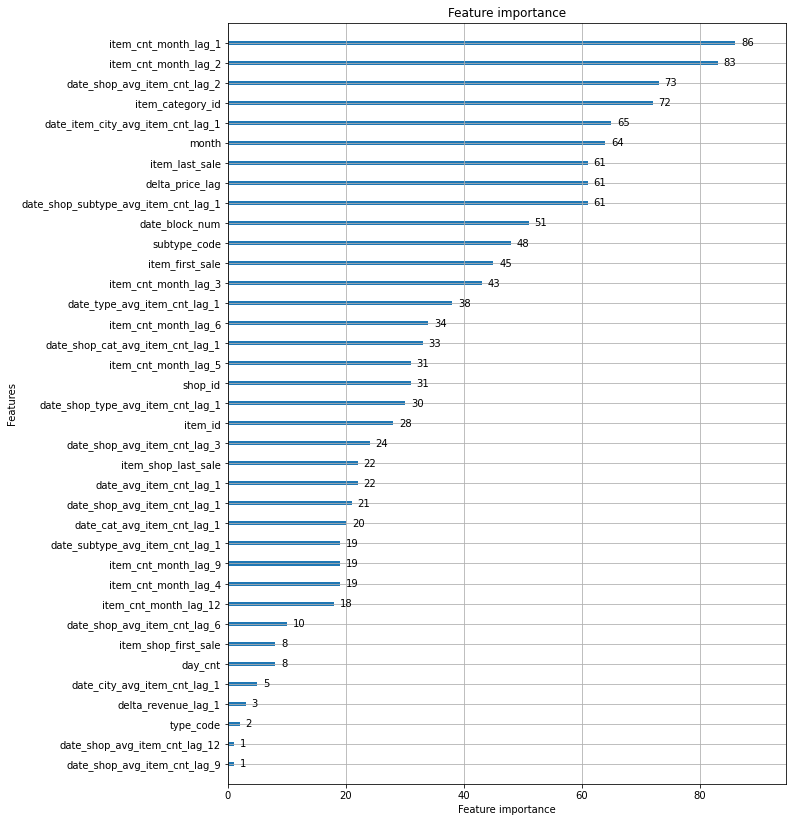

In [92]:
#importance = pd.DataFrame(model.feature_importance(), index=X_train.columns, columns=['importance'])
fig, ax = plt.subplots(1,1,figsize=(10, 14))
lgb.plot_importance(booster=model, ax=ax)